# Genetic Algorithms Lab

This notebook contains the work done by **Valentin Ringlet (i6191244)** and **Nick Oikonomou (i6201767)**.

- First, we'll define a generic genetic algorithm framework.

- Second, we'll implement the knapsack problem for the genetic algorithm framework.

- Third, we'll implement the travelling salesman problem (TSP) for the genetic algorithm framework.

In [1]:
# Import any needed libraries
import numpy as np
import matplotlib.pyplot as plt
import random

## Generic genetic algorithm framework

We will first implement the generic genetic algorithm framework.
To make it as customisable as possible, the generic genetic algorithm functions rely on functions provided as parameters to the functions.
The following subsections will provide first the generic genetic algorithm function that calls the generic functions for:
- selection of individuals to keep in the next generation

- crossover of individuals to generate new children

- mutation of individuals (with a certain probability)

In [2]:
def generic_genetic_algo(starting_population, number_iterations,
                         selection_population_size, select_individual_for_next_generation_fct,        # for selection function
                         select_individual_for_reproduction_fct, crossover_fct,                       # for crossover function
                         mutation_proba, apply_mutation_fct                                           # for mutation function
                        ):
    ''' Use the functions defined above for selection, crossover, mutation to run a genetic algorithm on the given population
    
        params:
            TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO
    '''
    # Save the size of the population
    pop_size = len(starting_population)
    
    # Then repeat creating a new population
    generation_num = 1
    previous_population = starting_population
    ''' TO SEE: do we want to do a more complex monitoring of the fitness function, then stop once the fitness values of the population aren't evolving anymore '''
    while generation_num <= number_iterations:
        # First, select individuals from the previous generation to create a mating pool for this generation
        population = selection(previous_population,
                               selection_population_size,
                               select_individual_for_next_generation_fct)
        
        # Then, restore a full population by doing crossover
        population = crossover(population,
                               pop_size,
                               select_individual_for_reproduction_fct,
                               crossover_fct)
        
        # Finally, apply mutations on the population
        population = mutation(population,
                              mutation_proba,
                              apply_mutation_fct)
        
        fitnesses = [ind.get_fitness() for ind in population]
        
        print(f'\nGeneration #{generation_num}')
        print(f'Min fitness: {np.min(fitnesses)}')
        print(f'Average fitness: {np.mean(fitnesses)}')
        print(f'Max fitness: {np.max(fitnesses)}')
        
        # Finally, move to the next generation and save the current population as the previous generation's population
        generation_num += 1
        previous_population = population
    
    
    
    return population[fitnesses.index(np.max(fitnesses))]

### Selection

In this section, we will define the function used for the selection of individuals from one generation to keep in the next generation.

In [3]:
def selection(population, num_selected_individuals, select_individual_fct):
    ''' Make a selection of individuals from the given population for the next generation.
    
        params:
            population: the previous population, from which we choose individuals
            num_selected_individuals: the number of individuals to select from the population
            select_individual_fct: the function that is used to select an individual to keep in the next generation
        
        return:
            a new population, with individuals picked from the input population,
                by using the provided function to select the individuals
    '''
    selected_list = []
    for i in range(num_selected_individuals):
        ind = select_individual_fct(population)
        while ind in selected_list:
            ind = select_individual_fct(population)
        selected_list.append(ind)
    return selected_list

### Crossover

In this section, we will define the function used for the crossover of individuals from a certain population to create children.

In [4]:
def crossover(population, final_size_population, select_parent_fct, crossover_single_fct):
    ''' Make the given population have new children by crossover.
    
        params:
            population: the individuals we start with
            final_size_population: the size we want the resulting population to be
            select_parent_fct: the function that can be used to get the individual parents
            crossover_single_fct: the function that is used to generate a child by crossover of two parents
        
        return:
            the population, with the addition of new children, to have "final_size_population" individuals in total.
                parents are selected by using the provided select_parent_fct function, and 
                the crossover is performed by using the crossover_single_fct
    '''
    start_size_population = len(population)
    
    ############################### NOT SURE IF THAT IS NECESSARY ########################################
    assert start_size_population <= final_size_population, "The population needs to be smaller than it should be after crossover"
    
    
    children = []
    for i in range(final_size_population - start_size_population):
        # Select 2 random individuals from the population
        parent1 = select_parent_fct(population)
        parent2 = select_parent_fct(population)
        # Make sure that they are different
        while (parent1 == parent2):
            parent2 = select_parent_fct(population)
        
        # Use the crossover_single function to create a new child
        child = crossover_single_fct(parent1, parent2)
        # And add it to the population
        children.append(child)
    
    # Finally, the new population is a list with the individuals from the starting population plus the children that were generated
    return population + children

### Mutation

In this section, we will define the function used for the mutation of individuals from a given population (with a certain mutation probability).

In [5]:
def mutation(population, mutation_proba, apply_mutation_fct):
    ''' Apply mutations to some individuals from the population
    
        params:
            population: the starting population
            mutation_proba: the probability of having a mutation in a certain individual 
                It should be a real value between 0 and 1.
            apply_mutation_fct: the function used for computing the mutated phenotype based on the provided phenotype
        
        return:
            the same population, except that some individuals might have been mutated
    '''
    # For each individual
    for i in range(len(population)):
        mutate_choice = np.random.rand()
        
        # if the random number is smaller than the probability of mutation 
        if mutate_choice <= mutation_proba:
            # We apply a mutation to that individual
            #   1. get the original phenotype of the individual
            old_phenotype = population[i].get_phenotype()
            
            #   2. compute the mutated phenotype
            mutated_phenotype = apply_mutation_fct(old_phenotype, population[i].get_possible_values())
            
            #   3. replace the old individual by the new one
            population[i] = type(population[i])(population[i].get_problem(), mutated_phenotype)
    
    return population

## Specific methods for performing selection, crossover, mutation

In this section, a number of specific functions will be defined for performing the selection, crossover or mutation steps of the generic genetic algorithm framework above.

The following aspects have functions defined for them:
- Selecting an individual from a given population:

    This can be used in the **selection** step, for selecting individuals from one generation to keep in the next.
    
    But it can also be used in the **crossover** step, for selecting individuals as parents to reproduce.
    
    The following methods are available as of now:
    - select_individual_uniform_proba
    - select_individual_roulette_wheel
    
- Performing a crossover based on two individuals provided as parents:

    This is used only in the **crossover** step, to actually perform the crossover.
    
    The following methods are available as of now:
    - crossover_single_uniform_proba

- Performing a mutation, given a individual to mutate:

    This is used in the **mutation** step only, to perform the mutation.
    
    The following methods are available as of now:
    - apply_mutation_uniform_proba

In [6]:
def select_individual_uniform_proba(population):
    ''' Choose and return an individual from the given population.
        The individual is chosen using uniform probability
    
        params: 
            population: the population of individuals to chose an individual from
        
        return:
            an individual chosen from the given population
    '''
    return np.random.choice(population)

def select_individual_roulette_wheel(population):
    ''' Choose and return an individual from the given population.
        The individual is chosen using the roulette wheel selection approach
    
        params: 
            population: the population of individuals to chose an individual from
        
        return:
            an individual chosen from the given population
    '''
    #Fitness scores
    fitness_scores = [individual.get_fitness() for individual in population]
    #Total sum of fitness scores
    sum_fitness_scores =  sum([individual.get_fitness() for individual in population])
    #Create distribution
    dist = fitness_scores / sum_fitness_scores
    
    return np.random.choice(population, p = dist)


def crossover_single_uniform_crossover(parent1, parent2, crossover_proba=0.5):
    ''' Create a new child using parents individual1 and individual2.
        This version of crossover_single() uses uniform crossover.
    
        params:
            parent1: one parent of the new child
            parent2: the other parent of the new child
            crossover_proba: the probability of swapping an element of parent1 with an element of parent2 
        
        return:
            a new individual
    '''
    # Retrieve the phenotypes of the two parents
    phenotype1 = parent1.get_phenotype()
    phenotype2 = parent2.get_phenotype()
    
    # Perform the uniform crossover
    for i in range(len(phenotype1)):
        random_num = np.random.rand()
        
        # If the random number is larger than a certain probability (50 %) then we swap the values
        if random_num <= crossover_proba:
            # Swap the values at that index
            temp = phenotype1[i]
            phenotype1[i] = phenotype2[i]
            phenotype2[i] = temp
    
    # Finally, generate a new individual of the same class as the original individuals, by using the phenotype
    child = type(parent1)(parent1.get_problem(), phenotype=phenotype1)
    
    return child

def apply_mutation_uniform_proba(phenotype, possible_replacement_values):
    ''' Select an index in the phenotype to mutate.
        This version uses an uniform probability for each index.
        
        params:
            phenotype: the list that will be mutated
    '''
    mutation_index = np.random.randint(len(phenotype))
    
    mutation_value = np.random.choice(possible_replacement_values)
    
    phenotype[mutation_index] = mutation_value
    
    return phenotype

### Knapsack problem implementation

In [7]:
class KnapsackProblem:
    def __init__(self,n, maximum_weight):
        ''' Initialize any needed variables
        
            params:
                n: number of items for the knapsack problem 
                maximum_weight: maximum weight that the bag contains
        '''
        #Initiliase maximum allowed weight
        self.maximum_weight = maximum_weight
        #Initialise items
        self.n = n
        #Initialise weights
        self.weights = []
        for i in range(self.n):
            self.weights.append(np.random.choice(np.arange(10)+1))
        #Initialise rewards
        self.rewards = np.arange(self.n) + 1   
    
    #Return rewards
    def get_rewards(self):
        return self.rewards
    
    #Return Weights
    def get_weights(self):
        return self.weights

In [8]:
class KnapsackIndividual:
    # The possible values a single index of the phenotype can take
    list_possible_values = ['0', '1']
    
    def __init__(self, knapsackproblem, phenotype = None):            # if needed, add more parameters
        ''' Initialize any needed variables
        
            params:
                phenotype: a phenotype value that we want to set the individual to
                knapsackproblem: The knapsack problem that the individual exists
        '''
        #Initialise problem
        self.knapsackproblem = knapsackproblem
        
        if phenotype ==  None:
            #Create and initialise genotype randomly
            self.genotype = ""
            for i in range(knapsackproblem.n):
                self.genotype += str(np.random.choice(np.arange(2)))
        else:
            # Create and initialise the genotype based on the given phenotype
            self.genotype = "".join(phenotype)
        
    def get_phenotype(self):
        ''' Return the phenotype of this individual as a list type object
        '''
        return [char for char in self.genotype]
    
    def get_weight(self):
        ''' Return the total weight of this solution '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        
        total_individual_weight = 0
        for i in range(len(phenotype)):
            if(phenotype[i] == "1"):
                total_individual_weight += (self.knapsackproblem.get_weights()[i])
        
        return total_individual_weight
    
    def is_legal(self):
        ''' Return the legality of the individual(weight)
        '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        #Keep track of the total weight and total reward of the individual
        total_individual_weight = self.get_weight()
        
        #Check for legality
        if total_individual_weight > (self.knapsackproblem.maximum_weight):
            return False;
        else:
            return True;
    
    def get_reward(self):
        ''' Return the total reward of this individual
        '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        #Total reward
        total_individual_reward = 0
        for i in range(len(phenotype)):
            if(phenotype[i] == "1"):
                total_individual_reward += (self.knapsackproblem.get_rewards()[i])
        return total_individual_reward
        
    def get_fitness(self):
        ''' Return the fitness score of this individual as a float
        '''
        if self.is_legal() == False:
            return 0;
        else:
            return self.get_reward();
    
    
    def get_possible_values(self):
        ''' Return a list of the possible values a single index of the phenotype can take.
        '''
        return self.list_possible_values
    
    def get_problem(self):
        return self.knapsackproblem

In [9]:
population = []
population_size = 100 # POPULATION SIZE CAN BE CHANGED HERE

problem = KnapsackProblem(10, 40)
for i in range(population_size):
    population.append(KnapsackIndividual(problem))


    
num_generation_runs = 10
selection_population_size = 20
select_individual_for_next_generation_fct = select_individual_roulette_wheel
select_individual_for_reproduction_fct = select_individual_uniform_proba
crossover_fct = crossover_single_uniform_crossover
mutation_proba = 0.05
apply_mutation_fct = apply_mutation_uniform_proba
best_individual = generic_genetic_algo(population, num_generation_runs,
                                        selection_population_size, select_individual_for_next_generation_fct,        # for selection function
                                        select_individual_for_reproduction_fct, crossover_fct,                       # for crossover function
                                        mutation_proba, apply_mutation_fct                                           # for mutation function
                                        )


print(f'\nTop performing individual: \nFitness score: {best_individual.get_fitness()}\nWeight: {best_individual.get_phenotype()}')

print(f'Problem: \nWeights are {problem.get_weights()}\nRewards are {problem.get_rewards()}')

# Use generic genetic algorithm with this


Generation #1
Min fitness: 0
Average fitness: 23.98
Max fitness: 47

Generation #2
Min fitness: 0
Average fitness: 27.88
Max fitness: 47

Generation #3
Min fitness: 0
Average fitness: 29.25
Max fitness: 49

Generation #4
Min fitness: 0
Average fitness: 30.2
Max fitness: 49

Generation #5
Min fitness: 0
Average fitness: 34.67
Max fitness: 49

Generation #6
Min fitness: 0
Average fitness: 36.32
Max fitness: 49

Generation #7
Min fitness: 0
Average fitness: 38.78
Max fitness: 47

Generation #8
Min fitness: 0
Average fitness: 40.45
Max fitness: 47

Generation #9
Min fitness: 0
Average fitness: 39.34
Max fitness: 47

Generation #10
Min fitness: 28
Average fitness: 42.31
Max fitness: 45

Top performing individual: 
Fitness score: 45
Weight: ['0', '0', '1', '1', '1', '1', '0', '1', '1', '1']
Problem: 
Weights are [9, 7, 3, 1, 3, 8, 7, 6, 7, 8]
Rewards are [ 1  2  3  4  5  6  7  8  9 10]


In [10]:
best_individual.get_weight()
np.sum([3, 4, 5, 6, 7, 8, 9, 10])

52

In [11]:
fitness_scores = []
for individual in population:
    fitness_scores.append(individual.get_fitness())

(array([19.,  2.,  4.,  7., 12., 14., 12., 14., 10.,  6.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <a list of 10 Patch objects>)

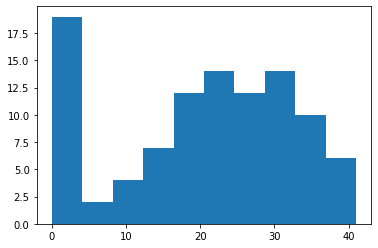

In [12]:
plt.hist(fitness_scores)

### Travelling salesman problem

In [13]:
class TSPProblem:
    def __init__(self, number_of_cities):
        '''Initiliaze the variables for the problem
        
            params:
                number_of_cities: define the number of cities in the problem
        '''
        #Initialise number of cities in the graph 
        self.number_of_cities = number_of_cities
        
        #Initialise nodes 
        self.nodes = np.arange(number_of_cities)
        
        #Define the representation
        self.representation = np.zeros((self.number_of_cities, self.number_of_cities));
        for i in range(number_of_cities):
            for j in range(number_of_cities):
                if i == j:
                    self.representation[i][j] = 0
                else:
                    distance = np.random.choice(np.arange(10) + 1)
                    self.representation[i][j] = distance
        
    def get_representation(self):
        return self.representation
    
    def get_nodes(self):
        return self.nodes
    
    def get_distance(self,node1,node2):
        return self.representation[node1][node2]

In [14]:
############## TEST TEST TEST #################
TSPproblem1 = TSPProblem(5)
print(TSPproblem1.get_representation())
print(TSPproblem1.get_nodes())
print(TSPproblem1.get_distance(0,4))

[[ 0.  6.  8.  4.  6.]
 [ 4.  0.  2.  9.  6.]
 [ 5.  3.  0.  5. 10.]
 [ 4.  9.  6.  0.  9.]
 [ 1.  1. 10.  3.  0.]]
[0 1 2 3 4]
6.0


In [15]:
class TSPIndividual:
    
    def __init__(self, tspproblem, phenotype=None):  # if needed, add more parameters
        ''' Initialize any needed variables
        
            params:
                tspproblem: a phenotype value that we want to set the individual to
        '''
        #Initialise the problem that we are working on
        self.tspproblem = tspproblem
        
        #List of possible values
        self.list_possible_values = self.tspproblem.get_nodes()
        
        if phenotype ==  None:
            #Create and initialise genotype randomly
            two_onwards = np.arange(1,tspproblem.number_of_cities)
            geno_temp = random.sample(list(two_onwards), len(two_onwards))
            geno_temp.append(0)
            geno_temp.insert(0, 0)
            self.genotype = geno_temp
        else:
            # Create and initialise the genotype based on the given phenotype
            self.genotype = phenotype
    
    def get_weight(self):
        total_weight = 0
        rep = self.tspproblem.get_representation()
        pheno = self.get_phenotype()
        for i in range(0,len(pheno)-1):
            total_weight += rep[pheno[i]][pheno[i+1]]
        return total_weight
    
    def get_pheno_without_start_end(self):
        l = list(filter(lambda x: x != 0, self.genotype))
        return l
        
    def get_phenotype(self):
        ''' Return the phenotype of this individual as a list type object
        '''
        #### ASK IF THIS IS WHAT WE WANT #### HOW IS GENOTYPE DIFFERENT THAN PHENOTYPE IN TSP PROBLEM?
        return self.genotype
    
    def get_fitness(self):
        ''' Return the fitness score of this individual as a float
        '''
        
        maximum = sum(sum(self.tspproblem.get_representation()))
        
        return maximum - self.get_weight()
    
    def get_possible_values(self):
        ''' Return a list of the possible values a single index of the phenotype can take.
        '''
        return self.list_possible_values
        
    def get_problem(self):
        return self.tspproblem

In [16]:
############## TEST TEST TEST #################
tsp_ind_example = TSPIndividual(TSPproblem1)
print(tsp_ind_example.get_phenotype())
print(tsp_ind_example.get_weight())
print(TSPproblem1.get_representation())
print(tsp_ind_example.get_fitness())
print(tsp_ind_example.get_problem())
print(tsp_ind_example.get_pheno_without_start_end())

[0, 4, 1, 3, 2, 0]
27.0
[[ 0.  6.  8.  4.  6.]
 [ 4.  0.  2.  9.  6.]
 [ 5.  3.  0.  5. 10.]
 [ 4.  9.  6.  0.  9.]
 [ 1.  1. 10.  3.  0.]]
84.0
[4, 1, 3, 2]
